## Translation

In [ ]:
! pip  install subword-nmt
! pip install nltk
! pip install torchtext

In [ ]:
import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2020-05-24 11:45:59--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  52.7MB/s    in 0.2s    

2020-05-24 11:45:59 (52.7 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE



### Main part

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9153
Unique tokens in target (en) vocabulary: 6684


In [ ]:
SRC.vocab.itos[::1000]

['<unk>',
 'загородного',
 'studio',
 'кондиционирования',
 'es',
 'элегантными',
 'near',
 'халкидики',
 'затененной',
 'финского']

In [ ]:
TRG.vocab.itos[::1000]

['<unk>',
 'lovely',
 'edinburgh',
 'citizens',
 'mushroom',
 'souvenirs',
 'mentioned']

Let's check the length distributions:

Length distribution in Train data


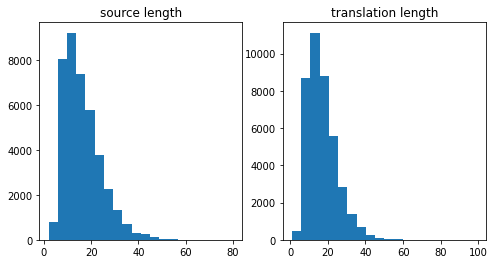

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


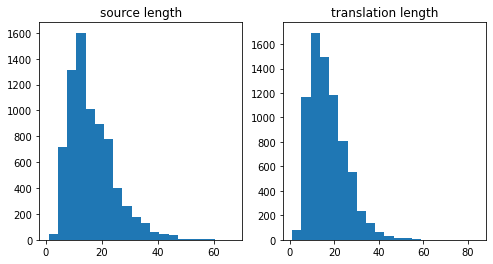

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

# Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 52x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 59x128 (GPU 0)]
torch.Size([59, 128]) torch.Size([52, 128])


# Simple encoder-decoder

In [ ]:
import my_network
import utils
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
model.apply(utils.init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9153, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6684, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6684, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
print(f'The model has {utils.count_parameters(model):,} trainable parameters')

The model has 14,839,580 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

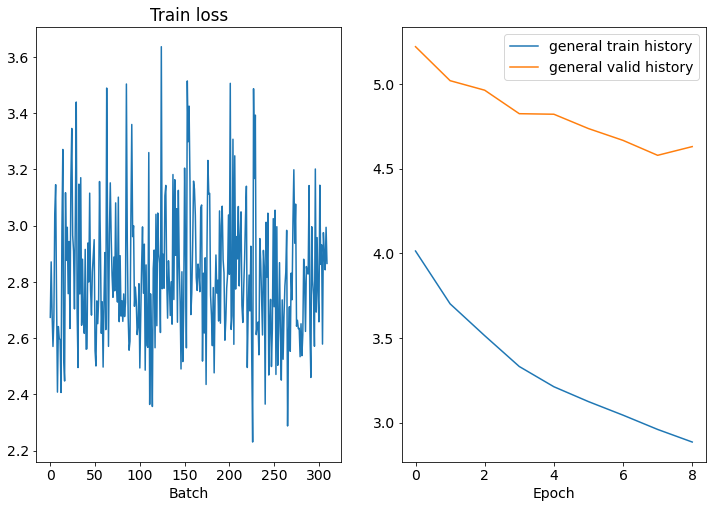

Epoch: 10 | Time: 1m 21s
	Train Loss: 2.824 | Train PPL:  16.843
	 Val. Loss: 4.497 |  Val. PPL:  89.760


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = utils.train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = utils.evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = utils.epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens\
get_text = utils.get_text
flatten = utils.flatten

batch = next(iter(test_iterator))

for idx in [1, 2, 3, 4, 5, 6]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    #teacher_forcing_turn_off => True if need to disable it
    utils.generate_translation(src, trg, model, TRG.vocab)

Original: guests can enjoy the on - site bar .
Generated: the property also has a bar .

Original: there is a 24 - hour front desk at the property .
Generated: a 24 - hour front desk .

Original: you will find a 24 - hour front desk at the property .
Generated: a 24 - hour front desk .

Original: there is a 24 - hour reception on site .
Generated: a 24 - hour front desk .

Original: the spacious rooms are all air - conditioned .
Generated: the air - conditioned rooms and a private .

Original: the property offers free parking .
Generated: free parking is available .



In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg
        
        output = model(src, trg, 0) #turn off teacher forcing
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([utils.get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([utils.get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])


59it [00:03, 16.18it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

15.798922671818463

# Try attention from scratch

In [ ]:
import attention_model
import imp
imp.reload(attention_model)
Encoder = attention_model.Encoder
Decoder = attention_model.Decoder
Seq2Seq = attention_model.Seq2Seq

max_length = 0
for batch in train_iterator:
  max_length = max(max_length, batch.src.shape[0], batch.trg.shape[0])

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
MAX_LENGTH = max_length

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)

model.apply(utils.init_weights)

print(f'The model has {utils.count_parameters(model):,} trainable parameters')

PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

The model has 11,556,125 trainable parameters


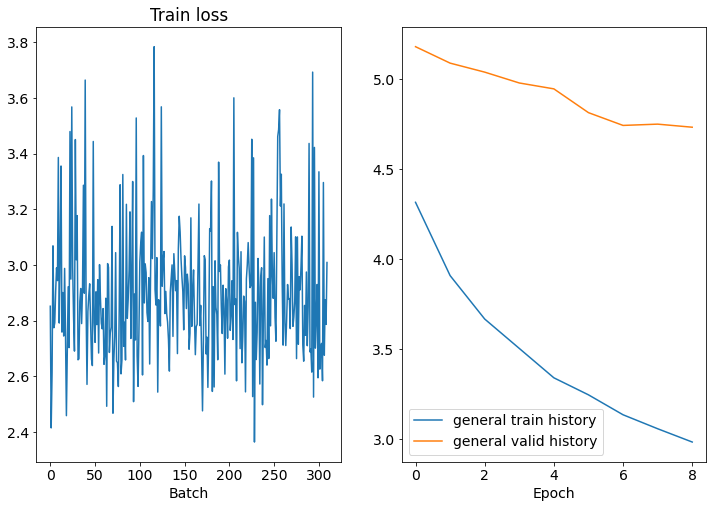

Epoch: 10 | Time: 6m 4s
	Train Loss: 2.900 | Train PPL:  18.179
	 Val. Loss: 4.695 |  Val. PPL: 109.448


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = utils.train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = utils.evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = utils.epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens\
get_text = utils.get_text
flatten = utils.flatten

batch = next(iter(test_iterator))

for idx in [1, 2, 3, 4, 5, 6]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    #teacher_forcing_turn_off => True if need to disable it
    utils.generate_translation(src, trg, model, TRG.vocab)

Original: guests can enjoy the on - site bar .
Generated: guests can enjoy a meal at the property .

Original: there is a 24 - hour front desk at the property .
Generated: the property is a a 24 - hour front desk .

Original: you will find a 24 - hour front desk at the property .
Generated: the property is a 24 - hour front desk .

Original: there is a 24 - hour reception on site .
Generated: the property is a 24 - hour front desk .

Original: the spacious rooms are all air - conditioned .
Generated: the air - conditioned rooms with air conditioning .

Original: the property offers free parking .
Generated: free parking .



In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg
        
        output = model(src, trg, 0) #turn off teacher forcing
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([utils.get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([utils.get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])


59it [00:09,  5.97it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

13.448067228527133

# Transformer

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

In [ ]:
import transformer_model
import imp
import utils
imp.reload(utils)
imp.reload(transformer_model)
Encoder = transformer_model.Encoder
Decoder = transformer_model.Decoder
Seq2Seq = transformer_model.Seq2Seq


INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
DIM_FEEDFORWARD = 1024
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
DROPOUT = 0.2
SRC_PAD_IDX = SRC.vocab.stoi['<pad>']
TRG_PAD_IDX = TRG.vocab.stoi['<pad>']
NHEAD = 2

enc = Encoder(
    input_dim=INPUT_DIM,
    emb_dim=EMB_DIM,
    nhead=NHEAD,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
    src_pad_idx=SRC_PAD_IDX
    )

dec = Decoder(
    output_dim=OUTPUT_DIM,
    emb_dim=EMB_DIM,
    nhead=NHEAD,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
    tgt_pad_idx=TRG_PAD_IDX
    )

model = Seq2Seq(enc, dec, device).to(device)

model.apply(utils.init_weights)

print(f'The model has {utils.count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
scheduler = StepLR(optimizer, 1.0, gamma=0.95)

train_history = []
valid_history = []

N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

The model has 11,301,660 trainable parameters


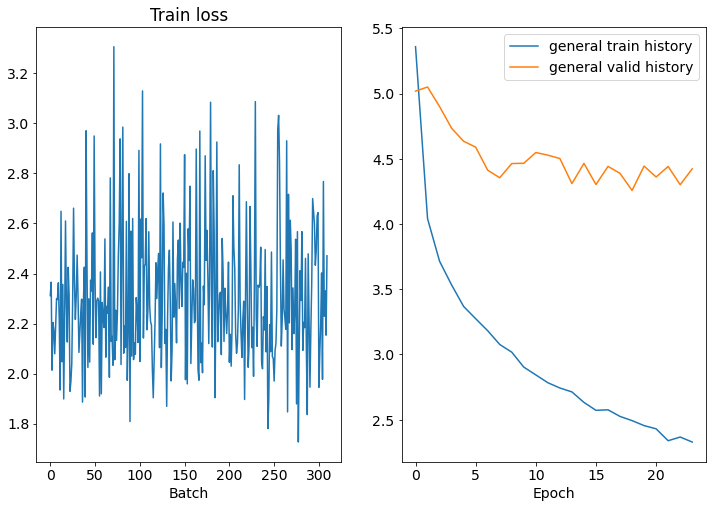

Epoch: 05 | Time: 3m 4s
	Train Loss: 2.306 | Train PPL:  10.030
	 Val. Loss: 4.451 |  Val. PPL:  85.715


In [ ]:
for epoch in range(5):
    
    start_time = time.time()
    
    train_loss = utils.train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = utils.evaluate(model, valid_iterator, criterion)
    scheduler.step(valid_loss)
    end_time = time.time()
    
    epoch_mins, epoch_secs = utils.epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f"transformer_epoch{epoch}.pt")
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

# Let's take a look at our network quality:

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens\
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1, 2, 3, 4, 5, 6]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    #teacher_forcing_turn_off => True if need to disable it
    utils.generate_translation(src, trg, model, TRG.vocab)

Original: guests can enjoy the on - site bar .
Generated: guests can enjoy the on - site bar .

Original: there is a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk at the property .

Original: you will find a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk at the property .

Original: there is a 24 - hour reception on site .
Generated: you will find a 24 - hour front desk at the property .

Original: the spacious rooms are all air - conditioned .
Generated: spacious rooms are spacious and air conditioning .

Original: the property offers free parking .
Generated: the property offers free parking .



In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import tqdm

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg
        
        output = model(src, trg, 0) #turn off teacher forcing
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([utils.get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([utils.get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

59it [00:14,  4.14it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

27.961029265961002

**Simple encoder-decoder BLEU**

14.527096405174165

In [ ]:
# corpus_bleu([[text] for text in original_text], generated_text) * 100

14.527096405174165

**Attention 40-epoch BLEU**

In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

18.791941245387374

**Transformer 25 epoch**

In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

28.07232714366198